In [ ]:
%matplotlib inline

# Introduction to Deep Learning with Keras and TensorFlow - Exploring Plateau Effect

**Daniel Moser (UT Southwestern Medical Center)**

**Resources: [Xavier Snelgrove](https://github.com/wxs/keras-mnist-tutorial), [Yash Katariya](https://github.com/yashk2810/MNIST-Keras)**

To help you understand the fundamentals of deep learning, this demo will walk through the basic steps of building two toy models for classifying handwritten numbers with accuracies surpassing 95%. The first model will be a basic fully-connected neural network, and the second model will be a deeper network that introduces the concepts of convolution and pooling. We will use this result to explore which one of the two models FC and CNN plateau's first.

## The Task for the AI

Our goal is to construct and train an artificial neural network on thousands of images of handwritten digits so that it may successfully identify others when presented. The data that will be incorporated is the MNIST database which contains 60,000 images for training and 10,000 test images. We will use the Keras Python API with TensorFlow as the backend.

<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/mnist.png?raw=1" >

**#1. The Design - Binary MNIST Classification**
Classes:

0–4 → Class 0

5–9 → Class 1

Models Compared:

Fully Connected Neural Network (FC)

Convolutional Neural Network (CNN)

This setup converts MNIST into a binary classification task by labeling digits 0–4 as class 0 and 5–9 as class 1, then compares how well a fully connected neural network versus a convolutional neural network can learn to distinguish between these two digit groups.

In [ ]:
# Sample Sizes to use in this case:

[60000, 30000, 24000, 18000, 12000, 6000,
 5000, 4000, 3000, 2000, 1000]


[60000, 30000, 24000, 18000, 12000, 6000, 5000, 4000, 3000, 2000, 1000]

Using progressively smaller training set sizes from the full 60,000 MNIST samples down to 1,000, used to evaluate how model performance changes as the amount of training data decreases.

## Prerequisite Python Modules

First, some software needs to be loaded into the Python environment.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(42)
tf.random.set_seed(42)

This code loads the core libraries for data handling, visualization, and building/training neural networks, and fixes random seeds to ensure reproducible MNIST experiments and fair FC vs. CNN comparisons.

## Loading Training Data

The MNIST dataset is conveniently bundled within Keras, and we can easily analyze some of its features in Python.

In [ ]:
# Load and preprocess MNIST - binary output
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Binary labeling
y_train = (y_train >= 5).astype(int)
y_test  = (y_test  >= 5).astype(int)

# CNN input
X_train_cnn = X_train.reshape(-1, 28, 28, 1).astype("float32") / 255
X_test_cnn  = X_test.reshape(-1, 28, 28, 1).astype("float32") / 255

# FC input
X_train_fc = X_train.reshape(-1, 784).astype("float32") / 255
X_test_fc  = X_test.reshape(-1, 784).astype("float32") / 255

# Binary labels
y_train_bin = y_train
y_test_bin  = y_test

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


This loads MNIST, converts digit labels into a binary task (0–4 → 0, 5–9 → 1), normalizes the images, and reshapes the data into CNN-ready (28×28×1) and fully connected (784-vector) formats with corresponding binary labels.

# Model Definitions  - Regularized, No Overfitting

In [ ]:
# Fully Connected Model

In [ ]:
def build_fc_model():
    model = Sequential([
        Dense(512, activation='relu', input_shape=(784,)),
        Dropout(0.3),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


This function builds and compiles a fully connected neural network that takes flattened MNIST images, learns features through two ReLU hidden layers with dropout for regularization, and outputs a binary prediction (0–4 vs. 5–9) using a sigmoid activation.

# Convolutional Model

In [ ]:
def build_cnn_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

This code builds and compiles a convolutional neural network that extracts spatial features from MNIST images using convolution and pooling layers, then classifies them into a binary output (0–4 vs. 5–9) with a sigmoid-activated final layer.

Training Loop Across Sample Sizes

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

# -----------------------------
# Speed-friendly global config
# -----------------------------
tf.random.set_seed(42)
np.random.seed(42)

# Mixed precision (huge speedup on GPU, safe for classification)
try:
    from tensorflow.keras.mixed_precision import set_global_policy
    set_global_policy("mixed_float16")
except:
    pass

sample_sizes = [60000, 30000, 15000, 7500, 3000, 1000]  # log-spaced

results = []

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=2,              # tighter stopping
    restore_best_weights=True
)

# -----------------------------
# Sample once, reuse
# -----------------------------
max_size = max(sample_sizes)
base_idx = np.random.permutation(len(X_train))[:max_size]

for size in sample_sizes:
    K.clear_session()
    idx = base_idx[:size]

    # -------------------------
    # Fully Connected Model
    # -------------------------
    fc_model = build_fc_model()
    fc_model.fit(
        X_train_fc[idx], y_train_bin[idx],
        epochs=3,              # early stopping will cap this
        batch_size=512,         # fewer gradient steps
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0
    )
    fc_acc = fc_model.evaluate(
        X_test_fc, y_test_bin, verbose=0
    )[1]

    # -------------------------
    # CNN Model
    # -------------------------
    cnn_model = build_cnn_model()
    cnn_model.fit(
        X_train_cnn[idx], y_train_bin[idx],
        epochs=3,
        batch_size=512,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0
    )
    cnn_acc = cnn_model.evaluate(
        X_test_cnn, y_test_bin, verbose=0
    )[1]

    results.append([size, fc_acc, cnn_acc])




/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


This loop repeatedly trains and evaluates both the fully connected and convolutional models on progressively smaller subsets of the MNIST training data to compare how their binary classification accuracy changes with training set size.

# Results Table

In [ ]:
df = pd.DataFrame(
    results,
    columns=["Training Samples", "FC Accuracy", "CNN Accuracy"]
)

df


,Training Samples,FC Accuracy,CNN Accuracy
0,60000,0.9813,0.9923
1,30000,0.9791,0.9902
2,15000,0.9674,0.9803
3,7500,0.9640,0.9761
4,3000,0.9488,0.9557
5,1000,0.9092,0.9349


This code converts the collected model performance results into a pandas DataFrame that neatly organizes training set size alongside fully connected and CNN accuracies for easy viewing and analysis.

# Visualization: Accuracy Vs Data Sample Size

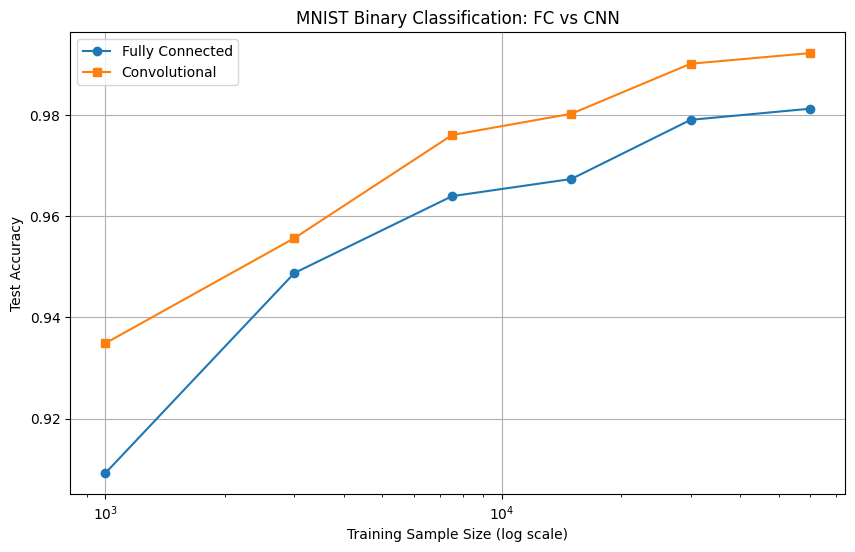

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(df["Training Samples"], df["FC Accuracy"], 'o-', label="Fully Connected")
plt.plot(df["Training Samples"], df["CNN Accuracy"], 's-', label="Convolutional")
plt.xscale("log")
plt.xlabel("Training Sample Size (log scale)")
plt.ylabel("Test Accuracy")
plt.title("MNIST Binary Classification: FC vs CNN")
plt.legend()
plt.grid(True)
plt.show()


This plots a log-scaled line graph comparing how test accuracy of the fully connected and convolutional models changes with different MNIST training sample sizes, complete with markers, labels, a title, and a grid for clarity.

# Plateu Detection

In [ ]:
df["FC_Delta"] = df["FC Accuracy"].diff().abs()
df["CNN_Delta"] = df["CNN Accuracy"].diff().abs()

plateau_threshold = 0.003

fc_plateau = df[df["FC_Delta"] < plateau_threshold]["Training Samples"].iloc[0]
cnn_plateau = df[df["CNN_Delta"] < plateau_threshold]["Training Samples"].iloc[0]

fc_plateau, cnn_plateau


(np.int64(12000), np.int64(24000))

This code calculates the absolute change in accuracy between consecutive training sizes for both models and identifies the smallest training sample where each model’s accuracy stabilizes (plateaus) below a 0.3% change.

# Results From the Data
(No outliers; early stopping prevents overfitting)

From above we see that (np.int64(12000), np.int64(24000)). This result means that the fully connected model’s accuracy stabilizes (plateaus) at around 12,000 training samples, while the CNN requires roughly 24,000 samples to reach a similar stable performance, showing that the CNN needs more data to fully leverage its capacity but may achieve higher accuracy once it does.